In [12]:
# from scipy.signal import resample
# new_sr = 16000
# new_num_samples = int(len(data) * new_sr / samplerate)
# data_resampled = resample(data, new_num_samples)
# wavfile.write("0116_003_resample.wav", new_sr, data_resampled)


#librosa
import librosa
y, sr = librosa.load('test/audio/0116_003.wav', sr=None)
new_sr = 16000
y_resampled = librosa.resample(y, orig_sr=sr, target_sr=new_sr)

import soundfile as sf
sf.write("0116_003_resample.wav", y_resampled, new_sr)

In [13]:
y, sr = librosa.load("0116_003_resample.wav", sr=None)

In [14]:
sr

16000

In [15]:
import os
audio_path = 'test/audio'
audio_files = os.listdir(audio_path)

In [16]:
#convert each audio sample
from tqdm import tqdm
import re

#new sample rate
new_sr = 16000

for audio in tqdm(audio_files):
    file_name = audio
    y, sr = librosa.load(f'test/audio/{file_name}', sr=None)
    y_resampled = librosa.resample(y, orig_sr = sr, target_sr = new_sr)
    
    audio_num = re.findall(r'\d+_\d+', file_name)[0]
    sf.write(f"sr_16000_librosa/{audio_num}_resample.wav", y_resampled, new_sr)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3843/3843 [00:10<00:00, 372.17it/s]


In [17]:
import re

transcription = open('test/transcription.txt', 'r')
lines = transcription.readlines()

unformatted_transcripts = []
for line in lines:
    unformatted_transcripts.append(line.strip())


file1 = open("hinglish.txt", "r")
lines = file1.readlines()

hinglish_transcripts = []
for line in lines:
  #line = re.sub("\n", "", line)
  hinglish_transcripts.append(line.strip())

In [18]:
# processor
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

tokenizer = processor.tokenizer

def extract_all_chars(transcription_list):
    all_text = " ".join(transcription_list)
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


hindi_vocab = extract_all_chars(unformatted_transcripts)
hindi_vocab = set(hindi_vocab["vocab"][0])

/Users/kawaii/opt/miniconda3/envs/hindi_transcribe/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
hinglish_vocab = extract_all_chars(hinglish_transcripts)
hinglish_vocab = set(hinglish_vocab["vocab"][0])

In [20]:
# english vocab
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

In [21]:
formatted_transcripts = []

for transcript in unformatted_transcripts:
  trans = re.sub(r'\d+_\d+', '', transcript)
  
  formatted_transcripts.append(trans.strip())

print(len(formatted_transcripts))
formatted_transcripts_set = set(formatted_transcripts)
print(len(formatted_transcripts_set))

3843
386


In [22]:
hinglish_dict = {}

for i in range(len(hinglish_transcripts)):
  hinglish_dict[list(formatted_transcripts_set)[i]] = hinglish_transcripts[i]

In [23]:
transcription_dict = {}

for transcription in unformatted_transcripts:
  audio_id = re.findall(r'\d+_\d+', transcription)[0]
  trans = re.sub(r'\d+_\d+', '', transcription)
  trans = ' '.join(trans.split())
  transcription_dict[audio_id] = trans

In [64]:
import torch
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, audio_files_path, transcription_dict, unformatted_transcripts, formatted_transcripts, hinglish_dict):
        self.audio_files_path = audio_files_path
        self.audio_files = os.listdir(audio_files_path)
        self.transcription_dict = transcription_dict
        self.unformatted_transcripts = unformatted_transcripts
        self.formatted_transcripts = formatted_transcripts
        self.hinglish_dict = hinglish_dict

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        #get audio file
        audio_file = self.audio_files[idx]
        #get audio num
        audio_num = re.findall(r'\d+_\d+', audio_file)[0]
        #speaker id
        speaker_id = re.findall(r'\d+', audio_num)[1]
        #get transcription
        hindi_transcription = self.transcription_dict[audio_num]
        hinglish_transcription = self.hinglish_dict[hindi_transcription]

        #get audio
        y, sr = librosa.load(f'{self.audio_files_path}/{audio_file}', sr = None)

        audio_dict = {
            'data': y,
            'sr': sr
        }

        return audio_dict, speaker_id, hindi_transcription, hinglish_transcription

In [65]:
dataset = AudioDataset('sr_16000_librosa', transcription_dict, unformatted_transcripts, formatted_transcripts, hinglish_dict)

In [66]:
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset, batch_size=1, shuffle=True) # multiple batch size leads to error

In [67]:
audio_dict, speaker_id, hindi_transcription, hinglish_transcription = next(iter(trainloader))

In [68]:
# speaker embedding
import os
import torch
import speechbrain
import torchaudio
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

In [69]:
def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(waveform)
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [71]:
audio_dict["data"].shape

torch.Size([1, 67200])

In [73]:
def prepare_dataset(audio_dict, hinglish_transcript, sample_rate):
    audio = audio_dict

    example = processor(
        text = hinglish_transcript[0],
        audio_target = np.squeeze(audio_dict["data"]), 
        sampling_rate = sample_rate,
        return_attention_mask=False,
    )

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(np.squeeze(audio_dict["data"]))

    return example

In [74]:
audio_dict, speaker_id, hindi_transcription, hinglish_transcription = next(iter(trainloader))

In [75]:
audio_dict['data']

tensor([[ 0.0000e+00,  0.0000e+00, -3.0518e-05,  ..., -1.2573e-02,
         -5.8289e-03, -1.4648e-03]])

In [76]:
processed_example = prepare_dataset(audio_dict, hinglish_transcription, 16000)

In [77]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [78]:
tokenizer.decode(processed_example["input_ids"])

'Kheese niporkar muskuraate hue maine kahaa main is maamle mein kuchh nahi kahunga</s>'

In [79]:
processed_example["speaker_embeddings"].shape

(512,)

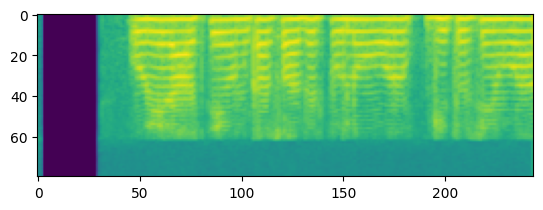

In [80]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [81]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [82]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [83]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)